## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [1]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [2]:
df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/downsampled_df_random.csv')
df.head()

,userId,wine,rate
0,976ec198-048f-405c-b6e6-b17ee1db1139,Nebbiolo d alba superiore,4
1,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Malvasia legno,3
2,13016d41-00bd-411c-83f5-2b95691696b7,Bianco,3
3,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet Franc,3
4,0a23a07a-8556-4ef6-85ee-d996f8ed619e,Talò Primitivo - Merlot,4


In [3]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [4]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,bc79b0e3-064d-4240-86de-e86499f577e8,2／17 @home #4,4
1,13016d41-00bd-411c-83f5-2b95691696b7,Sauvignon,4
2,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Terrano,2
3,5ccd8030-047b-432c-a630-d784ab415756,Vendemmia,2
4,a3b393ad-38d5-4c5a-b814-5fec18a1fa9d,New Wine,4
5,f4efa18b-06a5-4417-9c92-8a3dedf8a92a,Wine Club Shiraz,5
6,4313b57d-e3f7-495e-bcfd-ff5c1bf15fcc,Rock,5
7,99654a70-c3bb-46f4-8697-b9345482e48d,Pinot Grigio Valdadige,4
8,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Sauvignon de la Tour,4
9,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Bonpas Reserue de Bonpas,4


In [5]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [6]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -4.30


## Matrix factorization
* A better approach

In [7]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [8]:
# from sklearn.model_selection import KFold

# # Assuming dls is your DataLoaders object
# kf = KFold(n_splits=8, shuffle=True, random_state=42)  # You can adjust the number of splits

# # Store the results of each fold
# results = []

# for fold, (train_idx, valid_idx) in enumerate(kf.split(dls.train_ds)):
#     print(f'Fold {fold + 1}')
    
#     # Create new learner for each fold
#     model = DotProductBias(n_users, n_movies, 50)
#     learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mse, rmse, mae])
    
#     # Train the model for a fixed number of epochs
#     learn.fit_one_cycle(10, 5e-3, wd=0.1)
    
#     # Evaluate on the validation set
#     val_metrics = learn.validate(dl=dls.valid)
    
#     # Store the results
#     results.append({
#         'fold': fold + 1,
#         'train_loss': learn.recorder.final_record[0],
#         'valid_loss': val_metrics[0],
#         'mse': val_metrics[1],
#         'rmse': val_metrics[2],
#         'mae': val_metrics[3],
#     })

# # Display the results for each fold
# import pandas as pd
# results_df = pd.DataFrame(results)
# print(results_df)
# # # CV = 8
# # # # acc = 30.25%, train_loss =  1.586101, valid_loss =  1.586101, mse = 1.586101, rmse = 1.259405, mae =  1.030692


#good model
#Working perfectly without cross validation
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
#wd = weight decay (L2 regularization)
learn.fit_one_cycle(10, 0.05, wd=0.1)
# # acc = 31.93% , train_loss = 0.354673, valid_loss = 1.377170, mse = 1.377170, rmse = 1.173529, mae = 0.941417


# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 31.09% , train_loss = 1.408604, valid_loss = 1.677418, mse = 1.677418, rmse = 1.295152, mae = 1.066595


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.745315,1.770087,1.770087,1.330446,1.103868,00:00
1,1.588704,1.543651,1.543651,1.242438,1.011021,00:00
2,1.182512,1.475194,1.475194,1.214576,0.964367,00:00
3,0.954850,1.428922,1.428922,1.195375,0.955917,00:00
4,0.810339,1.392383,1.392383,1.179993,0.942757,00:00
5,0.689019,1.389631,1.389631,1.178826,0.943264,00:00
6,0.576716,1.377108,1.377108,1.173502,0.935033,00:00
7,0.486772,1.376639,1.376639,1.173303,0.939796,00:00
8,0.413902,1.377145,1.377145,1.173518,0.941438,00:00
9,0.354673,1.377170,1.377170,1.173529,0.941417,00:00


SuggestedLRs(valley=0.00363078061491251)

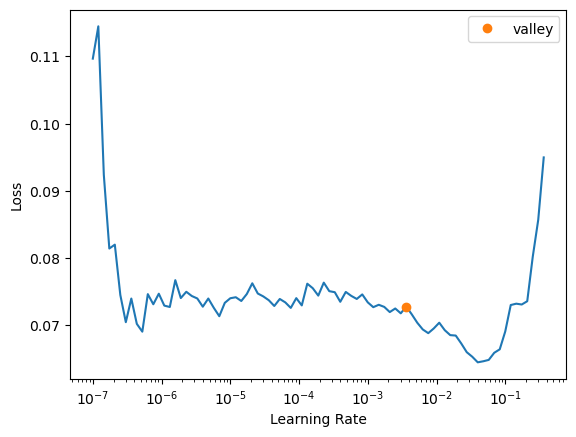

In [9]:
learn.lr_find()

In [10]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Ale Pinot Nero Alto Adige
Ribolla Cormons
Brunello di Montalcino Riserva Vigna Paganelli
Vitovska acciaio
Friulano


In [11]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 3.23
Predicted rating for user '50' and 'cabernet sauvignon': 2.74


In [12]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,55,420,4,3.006959
1,119,172,5,2.752235
2,126,377,3,2.793130
3,167,408,3,2.753681
4,88,416,3,3.046529
5,161,469,5,3.216742
6,111,408,2,3.528028
7,35,306,5,3.295414
8,165,406,3,2.675889


In [13]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(['Terrano', 'Chardonnay', 'Vitovska acciaio', 'Pinot Grigio',
       'Bollicina', 'Chianti', 'Cabernet Franc', 'Cabernet Sauvignon',
       'Malvasia', 'Merlot'], dtype=object)

In [14]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MAE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df


RMSE: 1.173528790473938
MAE: 1.3771697282791138
MAE: 0.9414169192314148
torch.Size([119])
torch.Size([119, 1])
The error is : 0.9414169192314148


,targets,predictions,error
0,3,3.282799,0.282799
1,1,5.013507,4.013507
2,5,3.243972,-1.756028
3,3,2.753681,-0.246319
4,4,3.333495,-0.666505
...,...,...,...
114,5,3.414102,-1.585898
115,5,3.295414,-1.704586
116,3,2.693689,-0.306311
117,3,2.780664,-0.219336


In [15]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
80,3,3.034444,0.034444,0.034444
58,4,4.035067,0.035067,0.035067
48,3,3.045109,0.045109,0.045109
57,3,3.046529,0.046529,0.046529
99,3,3.049570,0.049570,0.049570
87,3,3.052484,0.052484,0.052484
107,4,4.057439,0.057439,0.057439
43,3,3.062700,0.062700,0.062700
98,4,3.924320,-0.075680,0.075680
40,3,3.099637,0.099637,0.099637


In [16]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
1,1,5.013507,4.013507,4.013507
71,1,3.023972,2.023972,2.023972
49,2,3.528028,1.528028,1.528028
108,2,3.256844,1.256844,1.256844
73,2,3.203721,1.203721,1.203721
69,2,3.058469,1.058469,1.058469
50,2,3.055866,1.055866,1.055866
52,3,4.006978,1.006978,1.006978
61,2,2.872642,0.872642,0.872642
20,2,2.751644,0.751644,0.751644


In [17]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 31.93%


In [18]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([119])
Targets shape: torch.Size([119, 1])


In [19]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([119])
Targets shape: torch.Size([119])


In [20]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 55
Predictions: 119
Targets: 119


In [21]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([119])
Targets: torch.Size([119])
